In [1]:
#set to false to compute raw data from scratch, may take a long time depending on the hardware
precompdata = True
precomploc = False

In [2]:
%%capture
#install Python modules
!pip install numpy pandas geopandas IP2Location matplotlib cloud_ips

In [3]:
#standard modules
import os
import json
import glob
import bz2
import ipaddress as ipa
import datetime as dt
from IPython.utils import io

#installed modules
import numpy as np
import pandas as pd; pd.set_option('precision',2)
import geopandas as gpd
import IP2Location as ipl
import matplotlib.pyplot as plt
import cloud_ips.network as cloud

In [4]:
%%capture
#to support progress bars, if not used replace 'progress_apply' with 'apply'
!pip install ipywidgets===7.0.1
from tqdm.notebook import tqdm; tqdm.pandas()

# Dataset compilation

## Filtering

In [5]:
#function to validate IPv4 address
def validateip(ip):
    try:
        ip = ipa.ip_address(ip)
    except:
        return None

    if ip.version == 4:
        if ip.is_global: return str(ip)
    
    return None

#test
print(validateip(''),validateip(np.nan),validateip(None),validateip('1.1.1'),validateip('127.0.0.1'), validateip('2a02:598:a::79:222'),validateip('147.229.1.1'))

None None None None None None 147.229.1.1


In [6]:
#function to process daily data of Atlas devices
#archivefile - a file from https://ftp.ripe.net/ripe/atlas/probes/archive/
def getpastday(archivefile):

    archivedate = os.path.basename(archivefile).split('.')[0]
    #these files are corrupted ['20180221','20220121','20220121'] - already removed from Atlas data

    #decompress and convert to dataframe
    archive = bz2.open(archivefile)
    day_js = json.load(archive)
    day_pf = pd.DataFrame(day_js["objects"])
    
    #leave only columns to work with
    day_pf = day_pf.drop(columns = day_pf.columns.difference(['id','latitude','longitude','status_name','address_v4','asn_v4','country_code']))
    day_pf = day_pf.rename(columns ={'latitude':'lat','longitude':'lon','address_v4':'ip','asn_v4':'asn','country_code':'cntr','status_name':'sts'})
    day_pf.id = day_pf.id.astype('object')

    #drop devices with other statuses than connected
    day_pf = day_pf.drop(day_pf.loc[day_pf.sts != 'Connected'].index)  
    day_pf.pop('sts')  

    #drop location NA and invalid
    day_pf = day_pf.drop(day_pf.loc[(day_pf.lat.isna()) | (day_pf.lon.isna())].index)
    day_pf = day_pf.drop(day_pf.loc[(day_pf.lat.abs() > 90) | (day_pf.lon.abs() > 180)].index)

    #drop country NA and ''
    day_pf = day_pf.drop(day_pf.loc[day_pf.cntr.isna()].index)
    day_pf = day_pf.drop(day_pf.loc[day_pf.cntr == ''].index)
    
    #country code to upper
    day_pf.cntr = day_pf.cntr.str.upper()

    #validate IPv4 addr (invalid address to NA)
    day_pf.ip = day_pf.ip.apply(lambda x:validateip(x))

    #drop IP NA and invalid
    day_pf = day_pf.drop(day_pf.loc[day_pf.ip.isna()].index) 
   
    #drop ASN NA 
    day_pf = day_pf.drop(day_pf.loc[day_pf.asn.isna()].index)
    day_pf.pop('asn') 

    #store archive date
    day_pf['date'] = archivedate
    
    return day_pf

#test
display(getpastday('atlas/20200101.json.bz2'))

,id,ip,cntr,lat,lon,date
0,1,82.95.114.207,NL,52.35,4.93,20200101
5,1000001,194.149.136.245,MK,41.83,22.00,20200101
7,1000003,193.0.10.94,NL,52.38,4.90,20200101
8,1000004,147.28.0.33,US,47.61,-122.34,20200101
10,1000006,147.28.0.36,US,47.61,-122.34,20200101
...,...,...,...,...,...,...
30151,980,193.163.221.174,DK,55.78,12.52,20200101
30156,986,90.89.161.44,FR,43.60,1.44,20200101
30158,989,185.227.73.50,NL,52.22,6.90,20200101
30168,998,91.41.221.225,DE,51.33,12.38,20200101


## Validity

In [7]:
if precompdata:
    #use precomputed data
    history_pf = pd.read_pickle('precomp/histdataset.pic')   
else:
    #this may take a long time depending on the HW

    #read Atlas archive files downloaded from https://ftp.ripe.net/ripe/atlas/probes/archive/
    atlas_ls = sorted(glob.glob('atlas/*'),reverse = False)
    atlas_pf = pd.DataFrame(atlas_ls, columns=['filename'])

    #process daily data
    atlas_pf['day_pf'] = atlas_pf.filename.progress_apply(getpastday)

    #link data to historical dataset
    history_pf = pd.concat(atlas_pf.day_pf.values,ignore_index=True)

    #drop IP addresses that repeated in a row of days per device, keep most distant past address in a row
    history_pf = history_pf.sort_values(by='date')
    history_pf = history_pf.drop_duplicates(subset=['id','ip'])

    #get rid of devices with country changed - we are not sure about the country in the entire dataset
    #get list of countries for each device
    cntr_ps = history_pf.groupby(['id']).cntr.unique()
    #get devices with more countries than one
    device_ls = cntr_ps.loc[cntr_ps.apply(len) > 1].index.to_list()
    #drop devices with more countries
    history_pf = history_pf.drop(history_pf.loc[history_pf.id.isin(device_ls)].index)

    #remove IP addresses that belong to cloud service providers
    #such addresses should not be used to derive location
    #numbers may be different if the address ranges of cloud providers change in the future 
    with io.capture_output() as captured:  #do not show matched ip ranges
        history_pf['is_cloud'] = history_pf.ip.apply(cloud.is_cloud)
    history_pf = history_pf.drop(history_pf.loc[history_pf.is_cloud == True].index)
    history_pf.pop('is_cloud')

    #compress lat lon
    history_pf['latlon'] = list(zip(history_pf.lat,history_pf.lon))
    history_pf.pop('lat');history_pf.pop('lon')

    #store historical dataset
    history_pf.to_pickle('precomp/histdataset.pic')
    history_pf.to_csv('history/histdataset.csv',index=False)
    
display(history_pf)

,ip,cntr,id,date,latlon
0,213.93.36.211,NL,3,20150101,"(52.3385, 4.9075)"
3988,168.96.7.80,AR,15271,20150101,"(-34.6025, -58.3795)"
3987,196.28.246.228,BF,15270,20150101,"(12.3475, -1.5195)"
3986,105.184.106.231,ZA,15267,20150101,"(-25.9095, 28.1905)"
3985,197.157.255.130,CG,15266,20150101,"(-3.9195, 15.2105)"
...,...,...,...,...,...
25031818,87.93.129.75,FI,14536,20221231,"(60.4105, 25.8785)"
25031937,80.136.185.98,DE,15146,20221231,"(49.4805, 8.4695)"
25031943,95.88.165.82,DE,15199,20221231,"(49.4415, 7.7615)"
25031973,37.99.40.198,KZ,15610,20221231,"(43.3175, 76.9575)"


# Historical location

## Geodatabase

In [8]:
#function to get country
def getcntr(ip):
    try:
        cntr = database.get_country_short(ip)
    except:  
        return None

    if cntr == '' or cntr == '-' or cntr == 'None':
        return None

    return cntr

print(getcntr(None),getcntr('147.229.141.1'),getcntr('91.234.48.117'),getcntr('83.161.151.63'))

None None None None


In [9]:
#locate IP addresses by commercial or free database
if precomploc:
    #use precomputed locations
    history_pf = pd.read_pickle('precomp/histlocation.pic')
else:
    
    #SHARED_MEMORY memory is used to load the whole database into memory for fast processing
    #if memory is limited, change to FILE_IO (default)
    #https://www.ip2location.com/development-libraries/ip2location/python

    #free database
    #database = ipl.IP2Location('geodata/IP2LOCATION-LITE-DB1.BIN','SHARED_MEMORY')
    #OR
    #commercial database    
    database = ipl.IP2Location('geodata/IP-COUNTRY.BIN','SHARED_MEMORY')

    #check database build date from encoded data
    print('Database (year/month/day)',end=' ');print(database._dbyear,database._dbmonth,database._dbday,sep='/')

    history_pf['iploc'] = history_pf.ip.progress_apply(getcntr)

    history_pf.to_pickle('precomp/histlocation.pic') 

display(history_pf)

Database (year/month/day) 22/8/26


0%|          | 0/1240961 [00:00<?, ?it/s]

,ip,cntr,id,date,latlon,iploc
0,213.93.36.211,NL,3,20150101,"(52.3385, 4.9075)",NL
3988,168.96.7.80,AR,15271,20150101,"(-34.6025, -58.3795)",AR
3987,196.28.246.228,BF,15270,20150101,"(12.3475, -1.5195)",BF
3986,105.184.106.231,ZA,15267,20150101,"(-25.9095, 28.1905)",ZA
3985,197.157.255.130,CG,15266,20150101,"(-3.9195, 15.2105)",CG
...,...,...,...,...,...,...
25031818,87.93.129.75,FI,14536,20221231,"(60.4105, 25.8785)",FI
25031937,80.136.185.98,DE,15146,20221231,"(49.4805, 8.4695)",DE
25031943,95.88.165.82,DE,15199,20221231,"(49.4415, 7.7615)",DE
25031973,37.99.40.198,KZ,15610,20221231,"(43.3175, 76.9575)",KZ


## Country & stats

In [10]:
#IP address geolocation in/out correct country
history_pf['res'] = 'out'

history_pf.res = history_pf.res.mask(history_pf.iploc == history_pf.cntr,'in')
history_pf

,ip,cntr,id,date,latlon,iploc,res
0,213.93.36.211,NL,3,20150101,"(52.3385, 4.9075)",NL,in
3988,168.96.7.80,AR,15271,20150101,"(-34.6025, -58.3795)",AR,in
3987,196.28.246.228,BF,15270,20150101,"(12.3475, -1.5195)",BF,in
3986,105.184.106.231,ZA,15267,20150101,"(-25.9095, 28.1905)",ZA,in
3985,197.157.255.130,CG,15266,20150101,"(-3.9195, 15.2105)",CG,in
...,...,...,...,...,...,...,...
25031818,87.93.129.75,FI,14536,20221231,"(60.4105, 25.8785)",FI,in
25031937,80.136.185.98,DE,15146,20221231,"(49.4805, 8.4695)",DE,in
25031943,95.88.165.82,DE,15199,20221231,"(49.4415, 7.7615)",DE,in
25031973,37.99.40.198,KZ,15610,20221231,"(43.3175, 76.9575)",KZ,in


In [11]:
#all IP addresses
print('All',len(history_pf))
#IP addresses in years
history_pf.date = pd.to_datetime(history_pf.date,format='%Y%m%d')
display(history_pf.groupby(history_pf.date.dt.year).ip.count())

All 1240961


date
2015    148060
2016    148935
2017    173145
2018    164917
2019    149272
2020    159722
2021    155075
2022    141835
Name: ip, dtype: int64

In [12]:
#IP addresses not located
print('Not located globally',len(history_pf.loc[history_pf.iploc.isna()]))
history_pf = history_pf.drop(history_pf.loc[history_pf.iploc.isna()].index)

Not located globally 252


# Evidential value

## Naive methods

In [13]:
#countries
countriesA_ls = ['IR','UA']

In [14]:
#IP addresses in countries
for cntr in countriesA_ls:
    print(cntr,len(history_pf.loc[history_pf.cntr == cntr]))

IR 33125
UA 11345


In [15]:
#IP addresses in countries per year
for cntr in countriesA_ls:
    histcntr_pf = history_pf.loc[history_pf.cntr == cntr].groupby(history_pf.date.dt.year).ip.count()
    print(cntr,histcntr_pf.to_dict())

IR {2015: 1457, 2016: 2159, 2017: 2918, 2018: 5337, 2019: 5650, 2020: 5561, 2021: 5539, 2022: 4504}
UA {2015: 1740, 2016: 1526, 2017: 1344, 2018: 1518, 2019: 1815, 2020: 1726, 2021: 739, 2022: 937}


IR


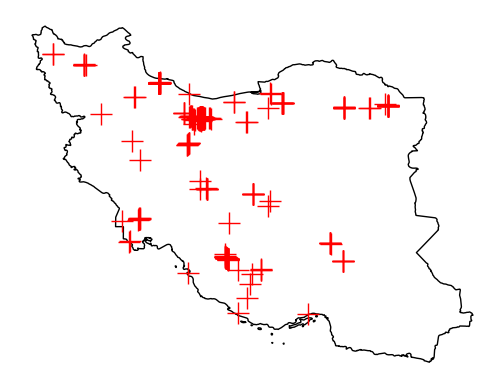

UA


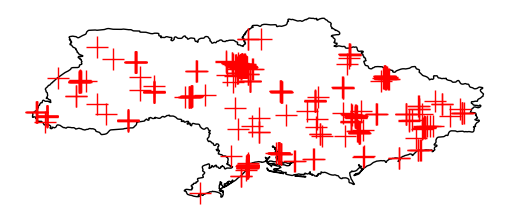

In [16]:
#geography

#country borders
worldcntr_gpf = gpd.read_file('geography/ne_10m_admin_0_countries')
worldcntr_gpf = worldcntr_gpf.drop(columns = worldcntr_gpf.columns.difference(['ISO_A2','geometry']))

for cntr in countriesA_ls:
    print(cntr)

    #process country IP addresses to geopandas
    cntraddr_pf = history_pf.loc[history_pf.cntr == cntr]
    #for faster plotting
    cntraddr_pf = cntraddr_pf.drop_duplicates(subset = ['latlon'])
    #transform coordinates
    cntraddr_pf['geocrd'] = gpd.points_from_xy([x[1] for x in cntraddr_pf.latlon],[x[0] for x in cntraddr_pf.latlon])
    cntraddr_gpf = gpd.GeoDataFrame(cntraddr_pf)

    #get country map
    cntrmap_gpf = worldcntr_gpf.loc[worldcntr_gpf.ISO_A2 == cntr]

    #validate country and lat/lon for possible mishmash
    #we use offline country reverse geocoding (within country borders)
    #use of an online service for such large numbers is time consuming; the limits of a free service may also be reached
    cntraddr_gpf['incntr'] = cntraddr_gpf.geocrd.within(cntrmap_gpf.geometry.values[0])
    #get list of IP addresses with lat/loc outside the country
    todrop_ps = cntraddr_gpf.loc[cntraddr_gpf.incntr == False].latlon
    #drop IP addresses with mishmashed values
    history_pf = history_pf.drop(history_pf.loc[(history_pf.cntr == cntr) & (history_pf.latlon.isin(todrop_ps))].index)

    #plot country map
    ax = cntrmap_gpf.plot(color='white', edgecolor='black')
    ax.set_aspect('equal')
    ax.ticklabel_format(style='plain', useOffset=False, axis='both')

    #plot IP address loc in country
    #repeat drop for the country as we already have transformed coordinates in cntraddr_gpf
    cntraddr_gpf = cntraddr_gpf.drop(cntraddr_gpf.loc[cntraddr_gpf.latlon.isin(todrop_ps)].index)
    cntraddr_gpf.geocrd.plot(ax=ax, marker='+', color='red', markersize=250,lw=1)

    plt.axis('off')
    plt.savefig('maps/fig_map'+cntr+'.pdf', bbox_inches='tight',pad_inches=0)
    plt.show()

In [17]:
#accuracy
for cntr in countriesA_ls:
    print(cntr, (history_pf.loc[history_pf.cntr==cntr].res.value_counts(normalize=True)*100).round(1).to_dict())

IR {'in': 94.1, 'out': 5.9}
UA {'in': 94.4, 'out': 5.6}


In [18]:
#global accuracy in 2016
print('global',(history_pf.loc[history_pf.date.dt.year == 2016].res.value_counts(normalize=True)*100).round(1).to_dict())

global {'in': 97.6, 'out': 2.4}


Global {2015: 98.1, 2016: 97.6, 2017: 98.5, 2018: 98.8, 2019: 99.2, 2020: 99.3, 2021: 99.6, 2022: 99.5}
min 97.6 2016 max 99.6 2021 diff 2.0

IR {2015: 96.6, 2016: 86.5, 2017: 91.0, 2018: 88.9, 2019: 92.4, 2020: 96.5, 2021: 98.8, 2022: 98.1}
min 86.5 2016 max 98.8 2021 diff 12.3

UA {2015: 92.1, 2016: 89.3, 2017: 95.3, 2018: 94.5, 2019: 98.2, 2020: 97.9, 2021: 92.5, 2022: 92.5}
min 89.3 2016 max 98.2 2019 diff 8.9



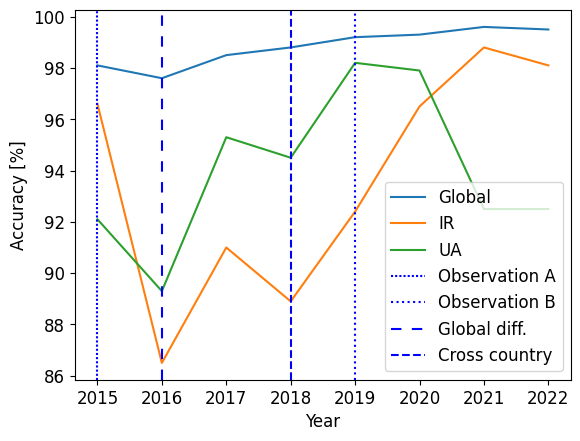

In [19]:
plt.figure()
plt.rcParams.update({'font.size': 12})

title = 'Global'

histglob_pf = history_pf.groupby(history_pf.date.dt.year).res.value_counts(normalize=True)
histglob_pf = (histglob_pf.unstack()['in']*100).round(1)
print(title, histglob_pf.to_dict())
print('min',histglob_pf.min(),histglob_pf.idxmin(),'max',histglob_pf.max(),histglob_pf.idxmax(),'diff',(histglob_pf.max() - histglob_pf.min()).round(2))
print()
histglob_pf.plot(xlabel='Year',ylabel='Accuracy [%]',label=title)

for i,cntr in enumerate(countriesA_ls):
    histcntr_pf = history_pf.loc[history_pf.cntr==cntr].groupby(history_pf.date.dt.year).res.value_counts(normalize=True)
    histcntr_pf = (histcntr_pf.unstack()['in']*100).round(1)
    print(cntr, histcntr_pf.to_dict())
    print('min',histcntr_pf.min(),histcntr_pf.idxmin(),'max',histcntr_pf.max(),histcntr_pf.idxmax(),'diff',(histcntr_pf.max() - histcntr_pf.min()).round(2))
    print()
    histcntr_pf.plot(xlabel='Year',ylabel='Accuracy [%]',label=cntr)

plt.axvline(x = 2015, color = 'b', linestyle = (0, (1, 1)),label = 'Observation A')
plt.axvline(x = 2019, color = 'b', linestyle = 'dotted',label = 'Observation B')
plt.axvline(x = 2016, color = 'b', linestyle = (0, (5, 5)),label = 'Global diff.')
plt.axvline(x = 2018, color = 'b', linestyle = 'dashed',label = 'Cross country')

plt.legend()
plt.savefig('figures/fig_naive.pdf', bbox_inches='tight',pad_inches=0)
plt.show()

## Evidential method

In [20]:
#countries
countriesB_ls = ['DE','FR','IT','AT','US','GB','IN']

In [21]:
#IP addresses
for cntr in countriesB_ls:
    print(cntr,len(history_pf.loc[history_pf.cntr == cntr]))

DE 565574
FR 53110
IT 39544
AT 28794
US 30330
GB 25924
IN 26464


In [22]:
#IP addresses in years
for cntr in countriesB_ls:
    histcntr_pf = history_pf.loc[history_pf.cntr == cntr].groupby(history_pf.date.dt.year).ip.count()
    print(cntr,histcntr_pf.to_dict())

DE {2015: 51752, 2016: 57376, 2017: 80010, 2018: 79136, 2019: 74314, 2020: 78636, 2021: 78169, 2022: 66181}
FR {2015: 10567, 2016: 6349, 2017: 7114, 2018: 5763, 2019: 5922, 2020: 7222, 2021: 5100, 2022: 5073}
IT {2015: 4273, 2016: 4204, 2017: 6061, 2018: 5052, 2019: 3723, 2020: 4182, 2021: 5678, 2022: 6371}
AT {2015: 4228, 2016: 6905, 2017: 6674, 2018: 4156, 2019: 1615, 2020: 1434, 2021: 1841, 2022: 1941}
US {2015: 4866, 2016: 3727, 2017: 3624, 2018: 3520, 2019: 3364, 2020: 3144, 2021: 3458, 2022: 4627}
GB {2015: 5056, 2016: 3788, 2017: 3668, 2018: 2843, 2019: 2332, 2020: 2869, 2021: 2850, 2022: 2518}
IN {2015: 653, 2016: 2214, 2017: 2177, 2018: 2800, 2019: 2497, 2020: 5340, 2021: 5987, 2022: 4796}


DE


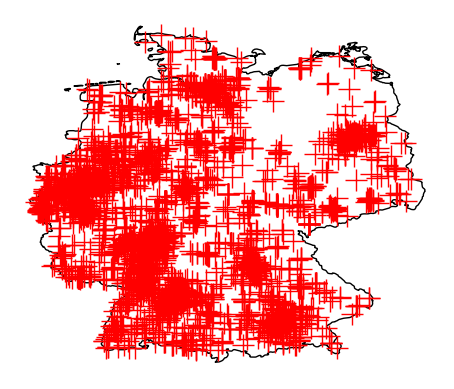

FR


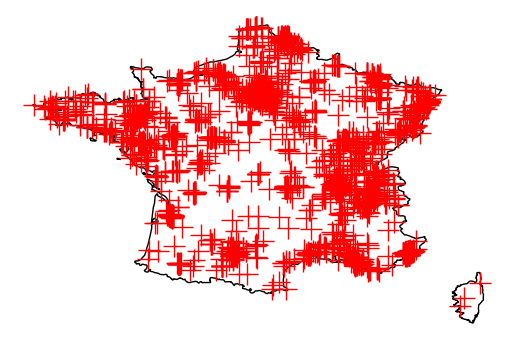

IT


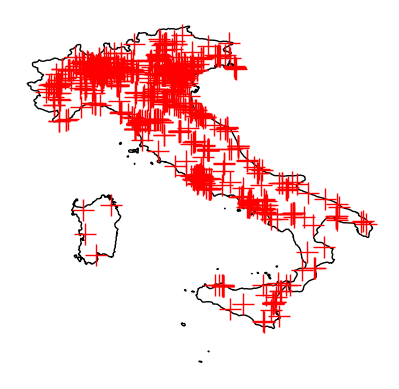

AT


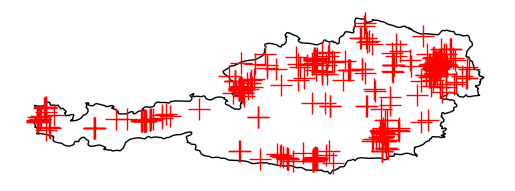

US


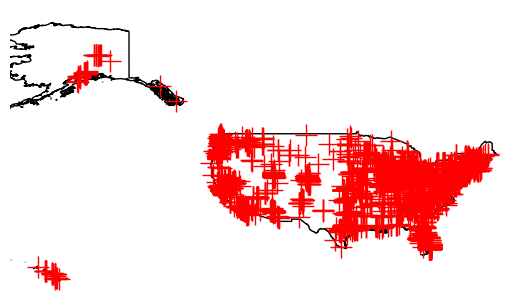

GB


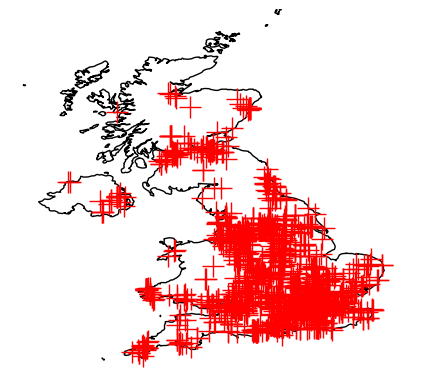

IN


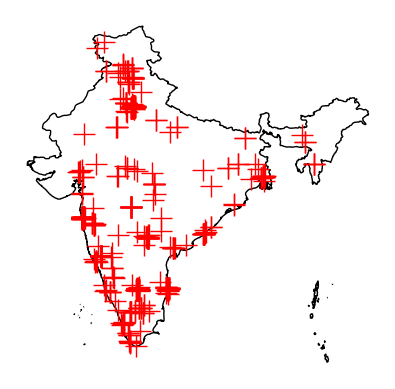

In [23]:
#geography

#European France
worldunits_gpf = gpd.read_file('geography/ne_10m_admin_0_map_units')
worldunits_gpf = worldunits_gpf.drop(columns = worldunits_gpf.columns.difference(['ISO_A2','geometry']))

for cntr in countriesB_ls:
    print(cntr)

    #process country IP addresses to geopandas
    cntraddr_pf = history_pf.loc[history_pf.cntr == cntr]
    #for faster plotting
    cntraddr_pf = cntraddr_pf.drop_duplicates(subset = ['latlon'])
    #transform coordinates
    cntraddr_pf['geocrd'] = gpd.points_from_xy([x[1] for x in cntraddr_pf.latlon],[x[0] for x in cntraddr_pf.latlon])
    cntraddr_gpf = gpd.GeoDataFrame(cntraddr_pf)

    #get country map
    cntrmap_gpf = worldcntr_gpf.loc[worldcntr_gpf.ISO_A2 == cntr]

    #for France use its European part
    if cntr == 'FR': cntrmap_gpf = worldunits_gpf.loc[worldunits_gpf.ISO_A2 == cntr]  

    #validate country and lat/lon for possible mishmash
    #we use offline country reverse geocoding (within country borders)
    cntraddr_gpf['incntr'] = cntraddr_gpf.geocrd.within(cntrmap_gpf.geometry.values[0])
    #get list of IP addresses with lat/loc outside the country
    todrop_ps = cntraddr_gpf.loc[cntraddr_gpf.incntr == False].latlon
    #drop IP addresses with mishmashed values
    history_pf = history_pf.drop(history_pf.loc[(history_pf.cntr == cntr) & (history_pf.latlon.isin(todrop_ps))].index)

    #plot country map
    ax = cntrmap_gpf.plot(color='white', edgecolor='black')
    ax.set_aspect('equal')
    ax.ticklabel_format(style='plain', useOffset=False, axis='both')

    #plot IP address loc in country
    #repeat drop for the country as we already have transformed coordinates in cntraddr_gpf
    cntraddr_gpf = cntraddr_gpf.drop(cntraddr_gpf.loc[cntraddr_gpf.latlon.isin(todrop_ps)].index)
    cntraddr_gpf.geocrd.plot(ax=ax, marker='+', color='red', markersize=250,lw=1)
    
    #fix US
    if cntr == 'US':
        plt.xlim([-165,-65])

    #fix GB
    if cntr == 'GB':
        plt.xlim(left=-9)
        plt.ylim(top=60)

    plt.axis('off')
    plt.savefig('maps/fig_map'+cntr+'.pdf', bbox_inches='tight',pad_inches=0)
    plt.show()

In [24]:
#accuracy
for cntr in countriesB_ls:
    print(cntr, (history_pf.loc[history_pf.cntr==cntr].res.value_counts(normalize=True)*100).round(1).to_dict())

DE {'in': 99.6, 'out': 0.4}
FR {'in': 98.7, 'out': 1.3}
IT {'in': 97.4, 'out': 2.6}
AT {'in': 99.6, 'out': 0.4}
US {'in': 99.4, 'out': 0.6}
GB {'in': 99.4, 'out': 0.6}
IN {'in': 99.8, 'out': 0.2}


DE {2015: 99.2, 2016: 99.0, 2017: 99.1, 2018: 99.9, 2019: 99.9, 2020: 99.9, 2021: 99.9, 2022: 100.0}
min 99.0 2016 max 100.0 2022 diff 1.0

FR {2015: 97.6, 2016: 97.3, 2017: 97.8, 2018: 99.6, 2019: 99.9, 2020: 99.9, 2021: 99.9, 2022: 99.2}
min 97.3 2016 max 99.9 2019 diff 2.6

IT {2015: 96.2, 2016: 92.8, 2017: 96.0, 2018: 96.9, 2019: 98.5, 2020: 99.4, 2021: 98.9, 2022: 99.9}
min 92.8 2016 max 99.9 2022 diff 7.1



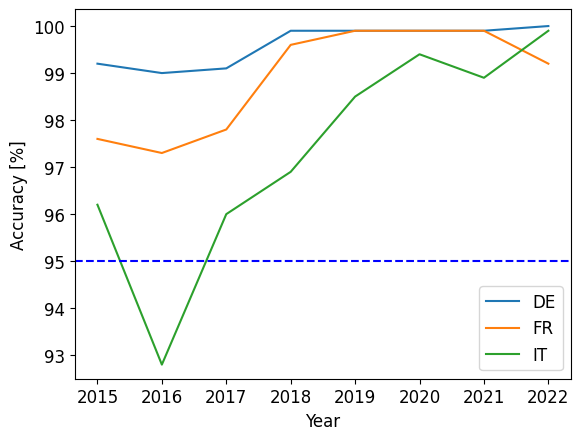

AT {2015: 99.7, 2016: 99.8, 2017: 99.2, 2018: 99.3, 2019: 99.6, 2020: 99.9, 2021: 99.7, 2022: 99.8}
min 99.2 2017 max 99.9 2020 diff 0.7

US {2015: 99.3, 2016: 99.7, 2017: 99.7, 2018: 99.2, 2019: 99.1, 2020: 99.1, 2021: 99.7, 2022: 99.4}
min 99.1 2019 max 99.7 2016 diff 0.6

GB {2015: 99.5, 2016: 99.2, 2017: 99.8, 2018: 99.7, 2019: 99.9, 2020: 99.8, 2021: 99.5, 2022: 97.9}
min 97.9 2022 max 99.9 2019 diff 2.0

IN {2015: 100.0, 2016: 99.1, 2017: 99.9, 2018: 99.5, 2019: 99.8, 2020: 100.0, 2021: 100.0, 2022: 99.7}
min 99.1 2016 max 100.0 2015 diff 0.9



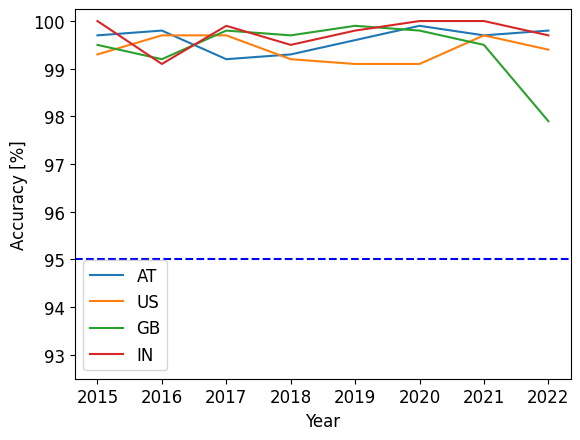

In [25]:
#historical changes
plt.figure()
plt.rcParams.update({'font.size': 12})
for i,cntr in enumerate(countriesB_ls):
    histcntr_pf = history_pf.loc[history_pf.cntr==cntr].groupby(history_pf.date.dt.year).res.value_counts(normalize=True)
    histcntr_pf = (histcntr_pf.unstack()['in']*100).round(1)
    print(cntr, histcntr_pf.to_dict())
    print('min',histcntr_pf.min(),histcntr_pf.idxmin(),'max',histcntr_pf.max(),histcntr_pf.idxmax(),'diff',(histcntr_pf.max() - histcntr_pf.min()).round(2))
    print()
    histcntr_pf.plot(xlabel='Year',ylabel='Accuracy [%]',label=cntr)
    #split to two graphs
    if i == 2:
        plt.axhline(y = 95, color = 'b', linestyle = '--')
        plt.ylim(bottom=92.5)
        plt.legend()
        plt.savefig('figures/fig_evidentialA.pdf', bbox_inches='tight',pad_inches=0)
        plt.show()
plt.axhline(y = 95, color = 'b', linestyle = '--')
plt.ylim(bottom=92.5)
plt.legend()
plt.savefig('figures/fig_evidentialB.pdf', bbox_inches='tight',pad_inches=0)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5826fecc-2de4-4d37-8c99-e16b13f0b2e0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>